In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score, pairwise_distances, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Tracked Dow Jones Tickers
tickers = [
    "AAPL", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
    "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT"
]

jow_dones_data = yf.download(tickers, start="2022-01-01", end="2023-01-01")
adj_close = jow_dones_data["Adj Close"]
returns = adj_close.pct_change().dropna()
corr_matrix = returns.corr()


[*********************100%%**********************]  30 of 30 completed


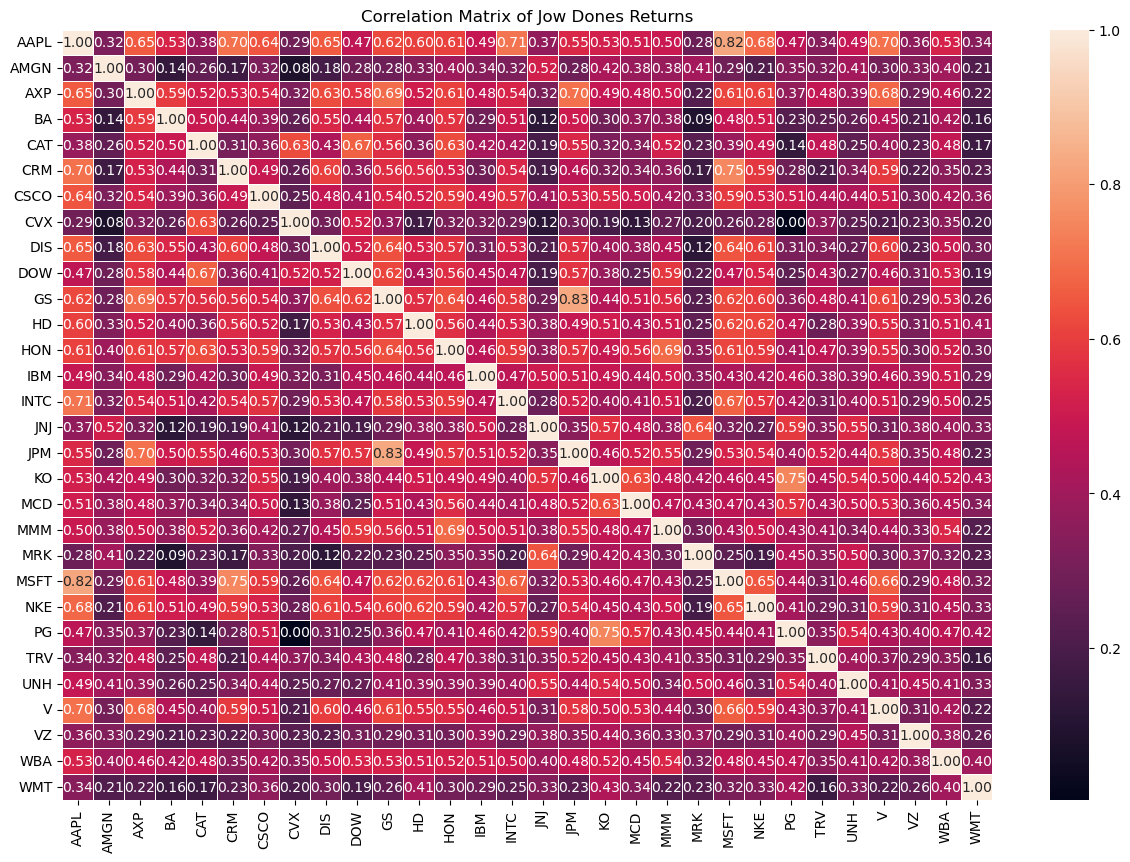

In [3]:
plt.figure(figsize=(15, 10))  # Set the figure size
sns.heatmap(corr_matrix, linewidth=0.5, fmt='0.2f', annot=True)
plt.title("Correlation Matrix of Jow Dones Returns")
plt.savefig('jow_dones_corr.png')
plt.show()

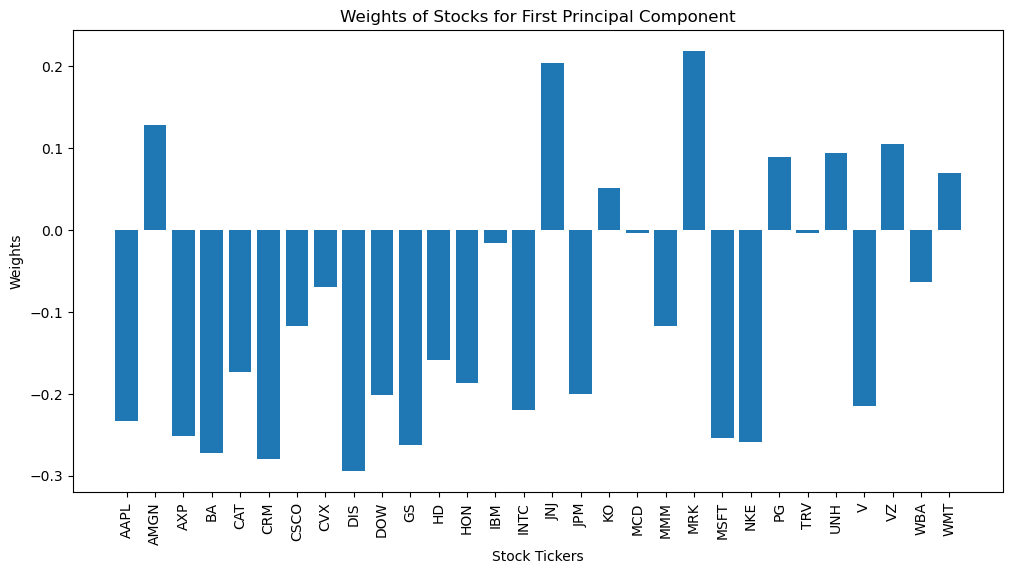

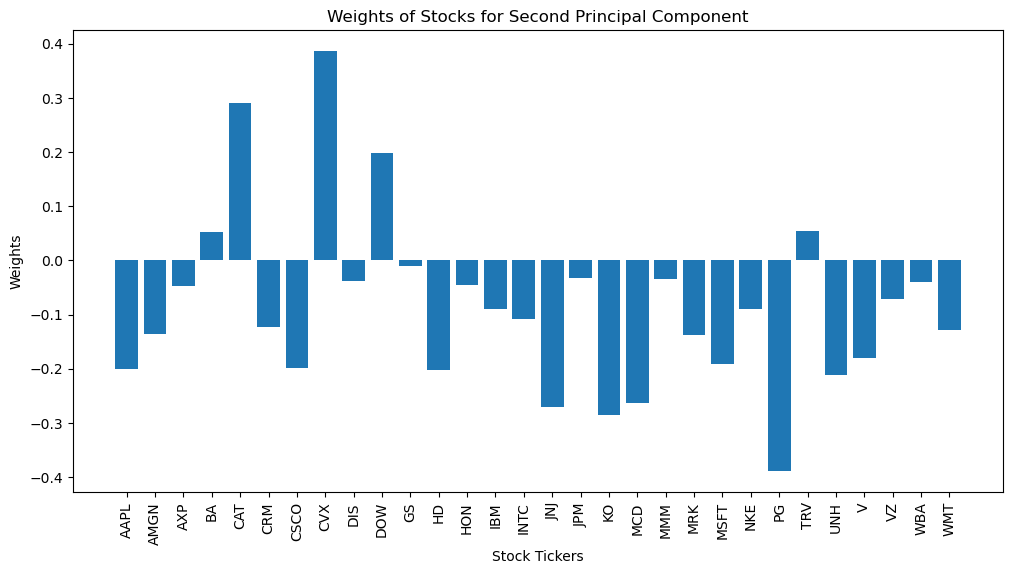

In [4]:
pca = PCA()
pca.fit(corr_matrix)  # Fit the PCA model to the correlation matrix

weights_first_pc = pca.components_[0]  # First principal component
weights_second_pc = pca.components_[1]  # Second principal component

# bar graph of the weights of each stock for the first principal component
plt.figure(figsize=(12, 6))
plt.bar(tickers, weights_first_pc)
plt.title("Weights of Stocks for First Principal Component")  # Add a title
plt.xlabel("Stock Tickers")  # add x-axis label
plt.ylabel("Weights")  # Adjust the y-axis label
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

# bar graph of the weights of each stock for the second principal component
plt.figure(figsize=(12, 6))
plt.bar(tickers, weights_second_pc)  # Adjust the bar graph size
plt.title("Weights of Stocks for Second Principal Component")  # Add a title
plt.xlabel("Stock Tickers")  # add x-axis label
plt.ylabel("Weights")  # Adjust the y-axis label
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

### PCA implementation without sklearn

In [5]:
# # get the eigenvectors and corresponding eigenvalues on the correlation matrix
# eigenvalues, eigenvectors = np.linalg.eigh(corr_matrix)


# eigenvalues = eigenvalues[::-1]  # Sort eigenvalues in descending order
# eigenvectors = eigenvectors[:, ::-1]  # Sort eigenvectors in descending order

# # # Calculate the explained variance ratio
# explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

# # Calculate the weights of each stock for the first and second principal components
# weights_first_pc = eigenvectors[:, 0]  # First principal component
# weights_second_pc = eigenvectors[:, 1]  # Second principal component


# # bar graph of the weights of each stock for the first principal component
# plt.figure(figsize=(12, 6))
# plt.bar(tickers, weights_first_pc)
# plt.title("Weights of Stocks for First Principal Component")  # Add a title
# plt.xlabel("Stock Tickers")  # add x-axis label
# plt.ylabel("Weights")  # Adjust the y-axis label
# plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
# plt.show()

# # bar graph of the weights of each stock for the second principal component
# plt.figure(figsize=(12, 6))
# plt.bar(tickers, weights_second_pc)  # Adjust the bar graph size
# plt.title("Weights of Stocks for Second Principal Component")  # Add a title
# plt.xlabel("Stock Tickers")  # add x-axis label
# plt.ylabel("Weights")  # Adjust the y-axis label
# plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
# plt.show()

### 1.3 insights

In [6]:
# Check if the first principal component is similar to the market
if np.allclose(weights_first_pc, np.ones_like(weights_first_pc) / len(weights_first_pc)):
    print("The first principal component is similar to the market (equal weight on each stock).")
else:
    print("The first principal component is not similar to the market.")

# Check if the second principal component is similar to the market
if np.allclose(weights_second_pc, np.ones_like(weights_second_pc) / len(weights_second_pc)):
    print("The second principal component is similar to the market (equal weight on each stock).")
else:
    print("The second principal component is not similar to the market.")

The first principal component is not similar to the market.
The second principal component is not similar to the market.


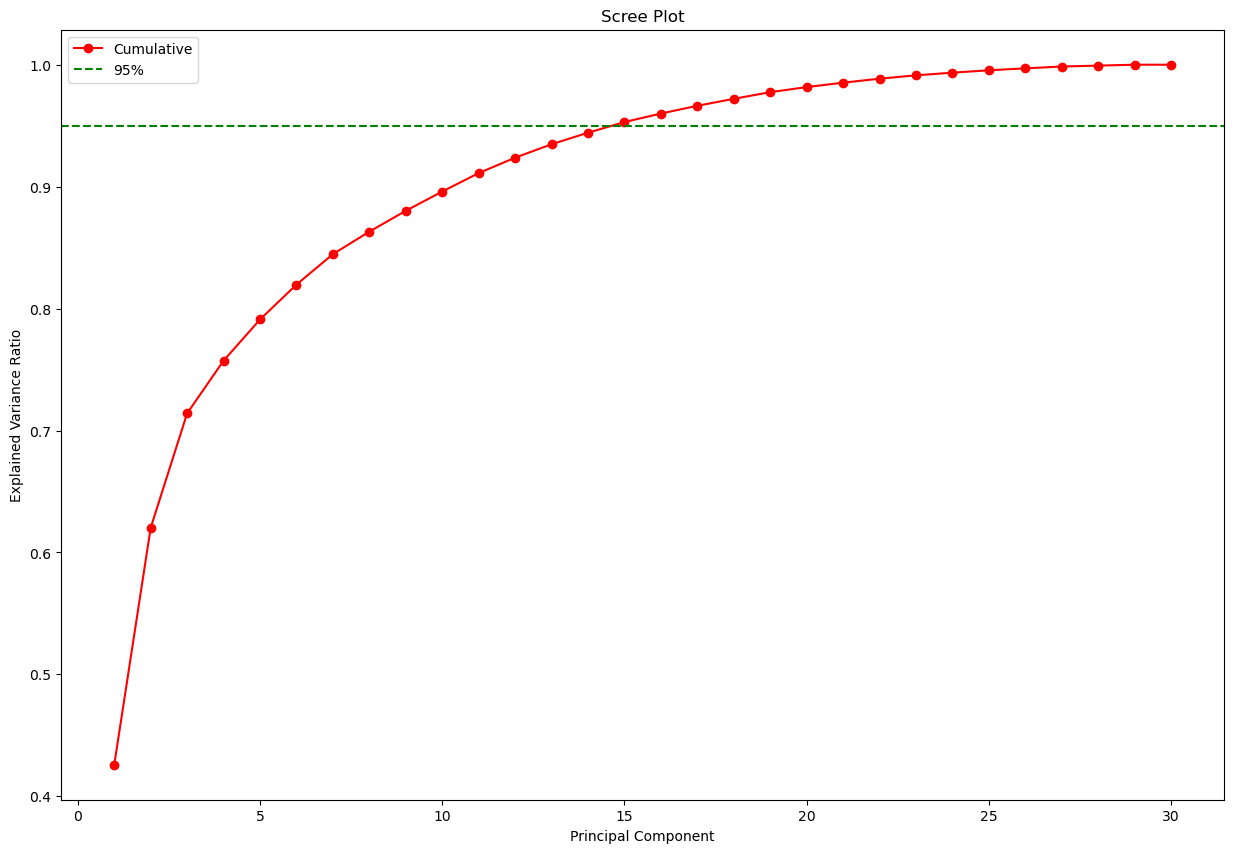

Number of components required to explain 95% of the variance: 15


In [7]:
explained_variance_ratio = pca.explained_variance_ratio_  # Get the explained variance ratio
cumulative_variance = np.cumsum(explained_variance_ratio)  # Get the cumulative explained variance ratio

# Plot the cumulative explained variance ratio
plt.figure(figsize=(15, 10))  # Set the figure size

# Create the "Scree" plot
# plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', label='Individual')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', label='Cumulative')
#plot a horizontal line at 0.95
plt.axhline(y=0.95, color='g', linestyle='--', label='95%')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.savefig('scree.png')
plt.show()

n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Find the number of components required to explain 95% of the variance
print(f"Number of components required to explain 95% of the variance: {n_components}")

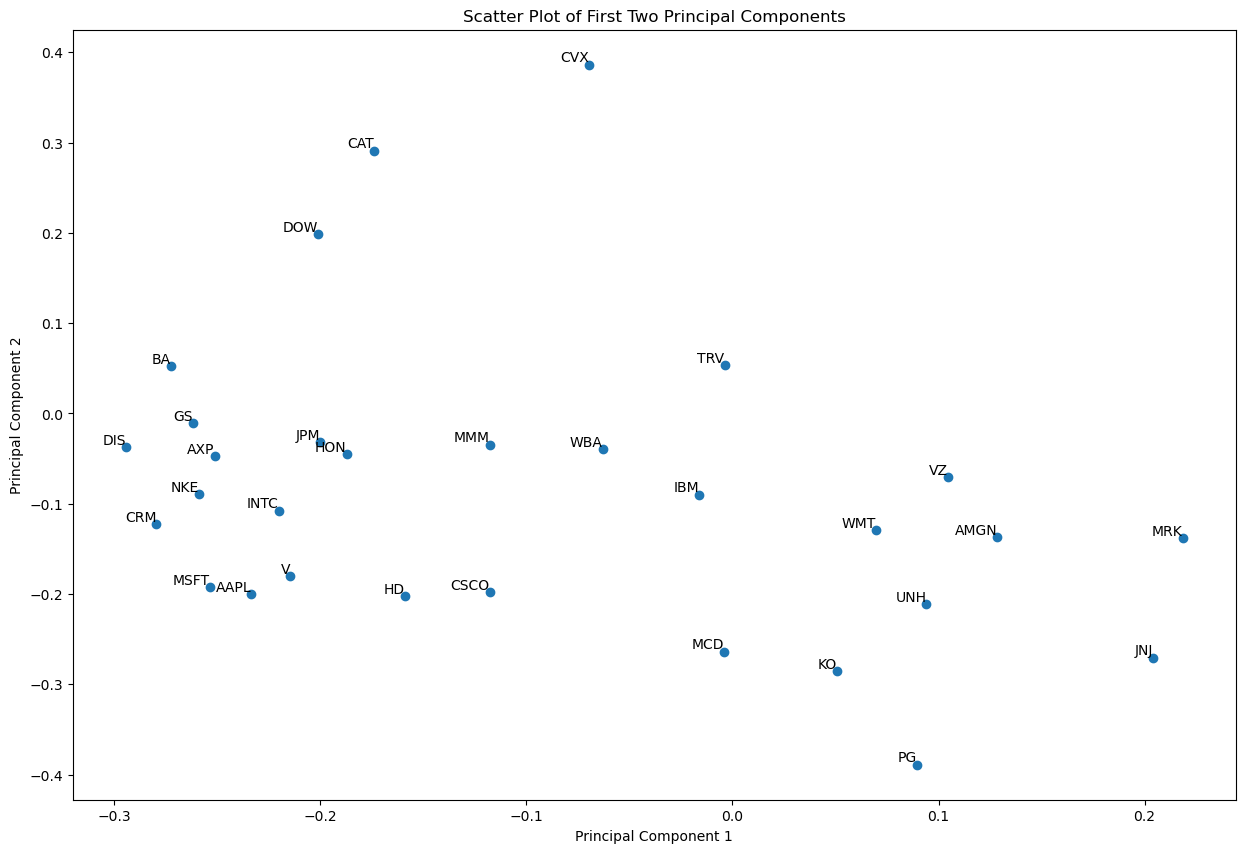

Three most distant stocks for Principal Component 1:
AMGN
JNJ
MRK
Three most distant stocks for Principal Component 2:
PG
CAT
CVX


In [8]:
# Obtain the values of the first two principal components for all stocks
pc1_values = weights_first_pc # Values of the first principal component for all stocks
pc2_values = weights_second_pc # Values of the second principal component for all stocks

plt.figure(figsize=(15, 10))

# Create a scatter plot
plt.scatter(pc1_values, pc2_values)
for i, label in enumerate(tickers):
    plt.text(pc1_values[i], pc2_values[i], label, fontsize=10, ha='right', va='bottom')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Scatter Plot of First Two Principal Components")
plt.savefig('scatter.png')  # Save the plot as a PNG file
plt.show()

# Calculate the mean of all stocks for each principal component
mean_pc1 = np.mean(pc1_values)
mean_pc2 = np.mean(pc2_values)

# Calculate the Euclidean distances from the mean for each stock and principal component
distances_pc1 = np.abs(pc1_values - mean_pc1)
distances_pc2 = np.abs(pc2_values - mean_pc2)

# Identify the three most distant stocks for each principal component
indices_pc1 = np.argsort(distances_pc1)[-3:]
indices_pc2 = np.argsort(distances_pc2)[-3:]

# Print the three most distant stocks for each principal component
print("Three most distant stocks for Principal Component 1:")
for index in indices_pc1:
    print(tickers[index])  # Replace stock_names with the actual list of stock names

print("Three most distant stocks for Principal Component 2:")
for index in indices_pc2:
    print(tickers[index])  # Replace stock_names with the actual list of stock names

### Question 2.3

In [9]:
# Compute the pairwise distance matrix
distance_matrix = np.sqrt(2 * (1 - corr_matrix))  # Compute the distance matrix using the correlation matrix

# distance_matrix_sklearn = pairwise_distances(corr_matrix)  # Compute the distance matrix using sklearn

C:\Users\mhabdulbaaki\AppData\Local\Temp\ipykernel_5548\2976190292.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


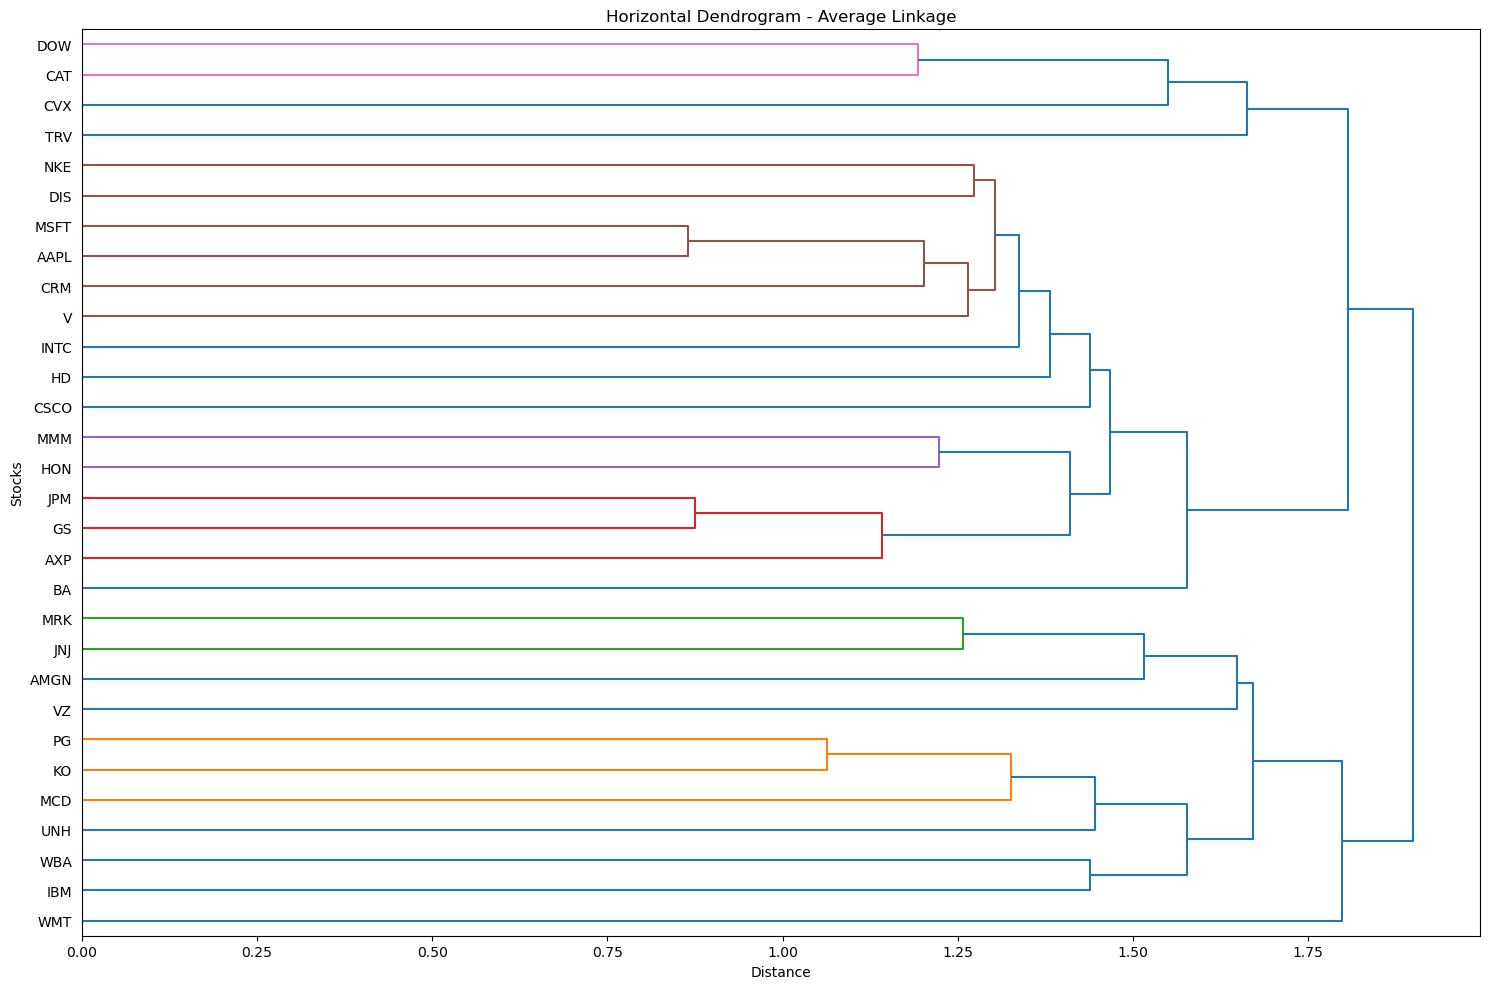

In [10]:
# Apply hierarchical clustering using average linkage
linkage_matrix = linkage(distance_matrix, method='average')

# Plot the dendrogram horizontally
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=tickers, orientation='right')

# Set plot aesthetics
plt.xlabel('Distance')
plt.ylabel('Stocks')
plt.title('Horizontal Dendrogram - Average Linkage')

# Rotate the y-axis labels for better readability if needed
plt.yticks(rotation=0)

# Adjust the plot layout
plt.tight_layout()
plt.savefig( 'dendrogram.png')  # Save the plot as a PNG file
# Show the plot
plt.show()

## 2.5

Cluster 1: ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DOW', 'HD', 'HON', 'IBM', 'JNJ', 'JPM', 'MMM', 'MRK', 'NKE']
Cluster 2: ['DIS', 'GS', 'INTC', 'KO', 'PG', 'TRV', 'V']
Cluster 3: ['MCD', 'MSFT', 'UNH', 'VZ', 'WBA']


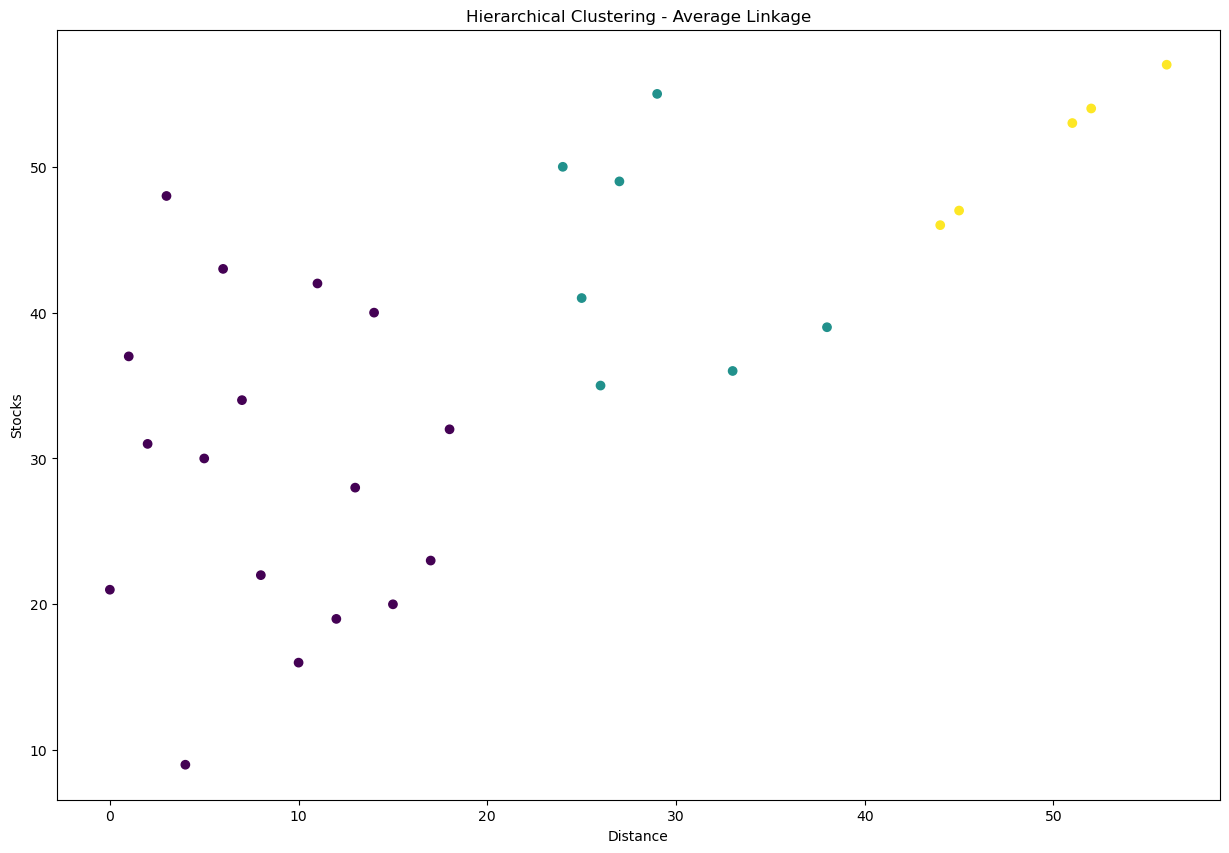

In [11]:
n_clusters = 3
model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
clusters = model.fit_predict(linkage_matrix)

cluster_one = []
cluster_two = []
cluster_three = []

for i,  cluster in enumerate(clusters):
    if cluster == 0:
        cluster_one.append(tickers[i])
    elif cluster == 1:
        cluster_two.append(tickers[i])
    else:
        cluster_three.append(tickers[i])
        
print( f"Cluster 1: {cluster_one}")
print( f"Cluster 2: {cluster_two}")
print( f"Cluster 3: {cluster_three}")

plt.figure(figsize=(15, 10))
plt.scatter(linkage_matrix[:,0], linkage_matrix[:,1], c=clusters, cmap='viridis')
plt.xlabel('Distance')
plt.ylabel('Stocks')
plt.title('Hierarchical Clustering - Average Linkage')  # Set the title of the plot
plt.savefig('clustering.png')  # Save the plot as a PNG file
plt.show()

# Question 3.4

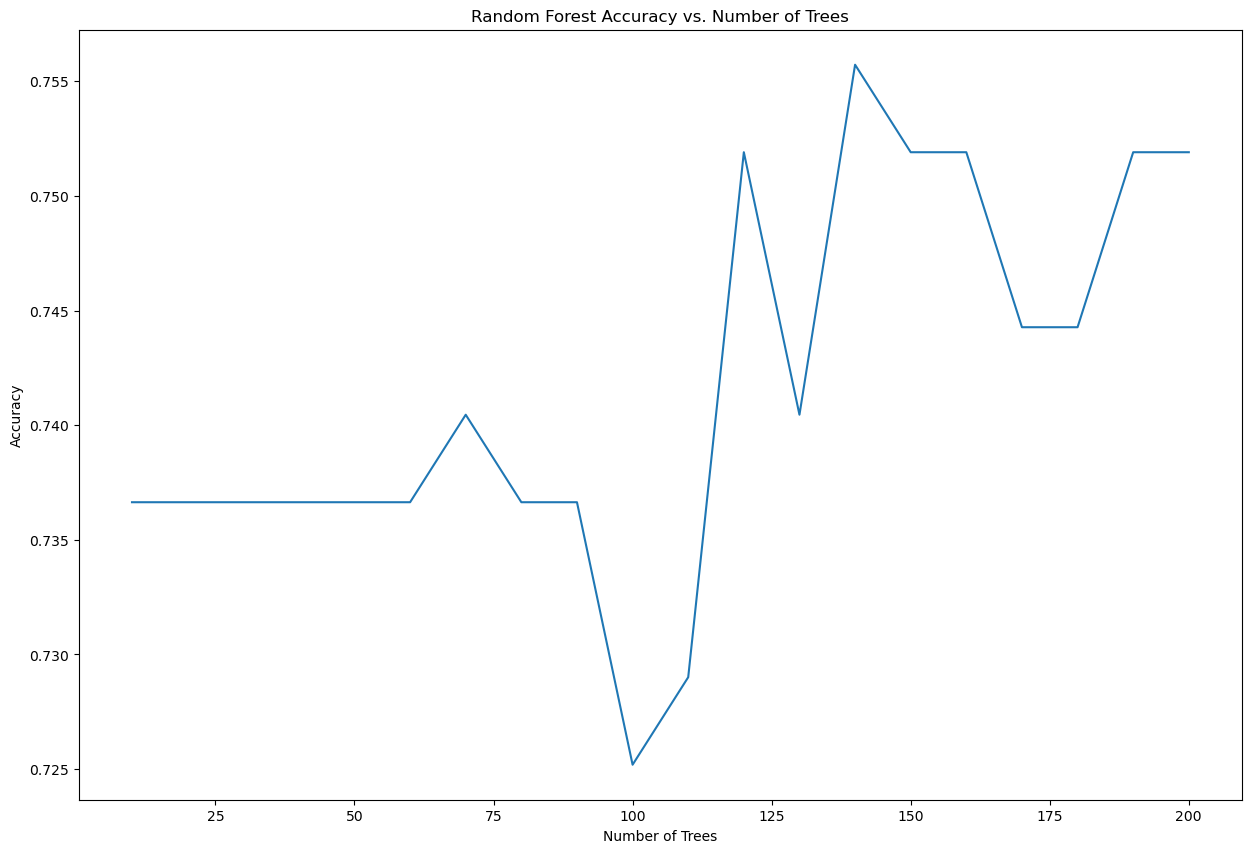

Optimal number of trees: 140


In [12]:
# Load the Titanic dataset
titanic_data = pd.read_csv('./titanic3.csv')

# Data preprocessing
# extract features matrix and target variable
features = ['pclass', 'sex', 'age',]
X = pd.get_dummies(titanic_data[features])  # Convert categorical variables to dummy variables
y = titanic_data['survived'] # target variable


# Handle missing values (e.g., fill missing ages with the mean)
X.loc[:,'age'] = X['age'].fillna(X['age'].mean())

# split data into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize a list to store accuracy scores
accuracy_scores = []

# Train and evaluate RF models with different numbers of trees
num_trees_range = range(10, 201, 10)  # Example range of number of trees
for num_trees in num_trees_range:
    # Initialize a random forest classifier with the current number of trees
    rf_model = RandomForestClassifier(n_estimators=num_trees, random_state=42)

    # Train the model on the training set
    rf_model.fit(X_train, y_train)  # X_train and y_train are the training features and labels

    # Make predictions on the testing set
    y_pred = rf_model.predict(X_test)  # X_test is the testing feature

    # Calculate accuracy score and append it to the list
    accuracy = accuracy_score(y_test, y_pred)  # y_test is the true labels for the testing set
    accuracy_scores.append(accuracy)

# Plot a graph of accuracy scores for different numbers of trees
plt.figure(figsize=(15, 10))
plt.plot(num_trees_range, accuracy_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.savefig('random_forest_optimal_trees.png')  # Save the plot as a PNG file
plt.show()

# Determine the optimal number of trees based on the graph
optimal_num_trees = num_trees_range[np.argmax(accuracy_scores)]
print("Optimal number of trees:", optimal_num_trees)

# 3.5

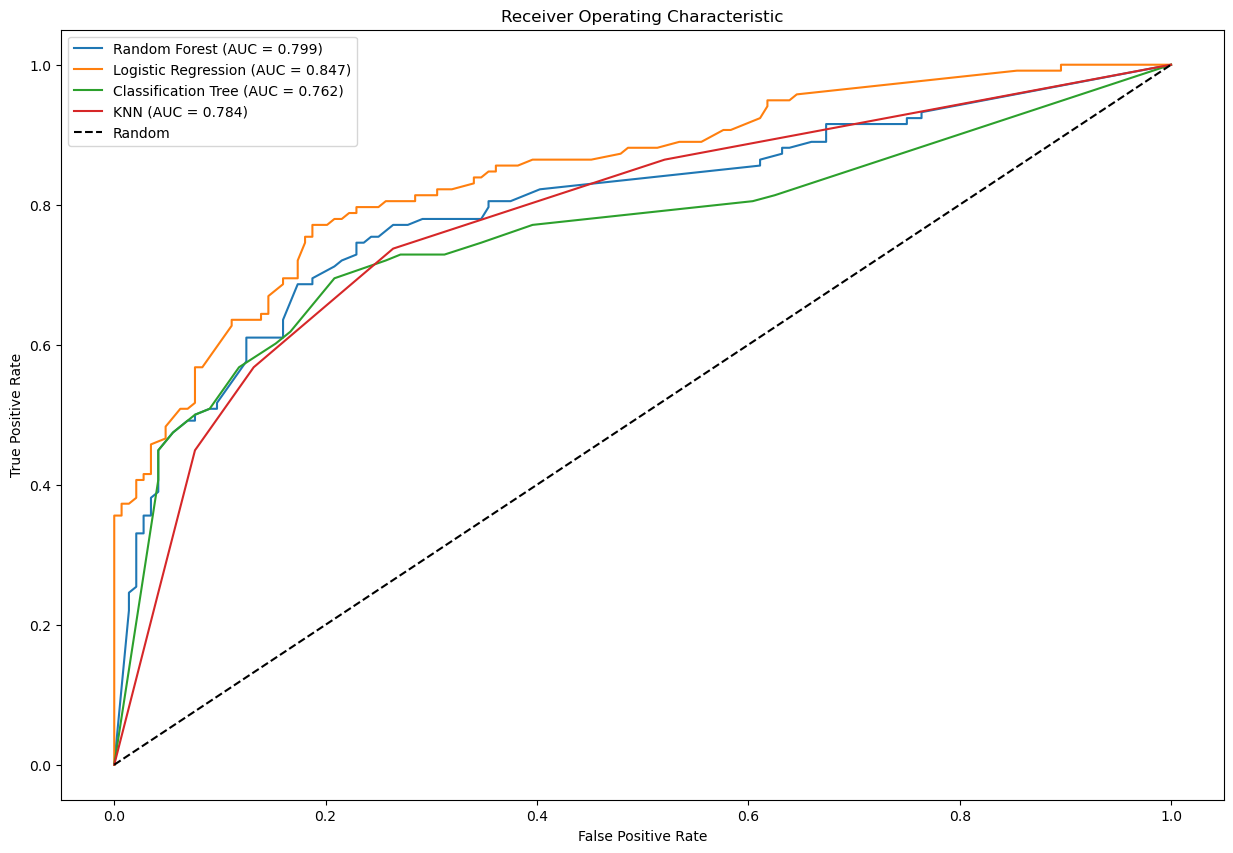

In [13]:
# Load the Titanic dataset
titanic_data = pd.read_csv('./titanic3.csv')

features = ['pclass', 'sex', 'age',]
X = pd.get_dummies(titanic_data[features])  # Convert categorical variables to dummy variables
y = titanic_data['survived'] # target variable


# Handle missing values (e.g., fill missing ages with the mean)
X.loc[:,'age'] = X['age'].fillna(X['age'].mean())

# split data into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Initialize and train the models
rf_model = RandomForestClassifier(n_estimators=optimal_num_trees)
logreg_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
knn_model = KNeighborsClassifier()

models = [rf_model, logreg_model, tree_model, knn_model]
model_names = ['Random Forest', 'Logistic Regression', 'Classification Tree', 'KNN']

# Initialize empty lists to store fpr and tpr values for each model
fprs = []
tprs = []
plt.figure(figsize=(15,10))
# Perform ROC analysis for each model
for model in models:
    # Train the model on the training set
    model.fit(X_train, y_train)  # X_train and y_train are the training features and labels

    # Make predictions on the testing set
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class

    # Calculate the false positive rate (fpr), true positive rate (tpr), and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Append the fpr and tpr values to the lists
    fprs.append(fpr)
    tprs.append(tpr)

    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label=model_names[models.index(model)] + f' (AUC = {auc:.3f})')

# Plot the ROC curves and compare the models
plt.plot([0, 1], [0, 1], 'k--', label='Random')  # Random classifier reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.savefig('ROC.png')  # Save the plot as a PNG file
plt.show()

# Question 4

In [14]:
red_wine = pd.read_csv("./winequality-red.csv", sep=";")  # Load the red wine dataset
white_wine = pd.read_csv("./winequality-white.csv", sep=";")  # Load the white wine dataset

## 4.2

In [ ]:
X = red_wine.drop("quality", axis=1)  # Drop the quality column from the red wine dataset
y = red_wine["quality"]  # Extract the quality column from the red wine dataset

# split data into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid to search
leaf_nodes = range(2,250,5)
param_grid = {'max_leaf_nodes': leaf_nodes}

# Initialize Random Forest classifier
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_rf_model.predict(X_test)

# # Evaluate the performance on the test set
# mse = mean_squared_error(y_test, y_pred)  # Calculate the mean squared error

search_scores = grid_search.cv_results_['mean_test_score']  # Get the mean test scores from the grid search

plt.figure(figsize=(12,8))  # Set the figure size
plt.plot(leaf_nodes, abs(search_scores))  # Plot the mean test scores as a function of the number of leaf nodes
plt.scatter(best_params['max_leaf_nodes'], abs(search_scores).min(), color='orange', label='optimal point')
plt.legend()  # Add a legend to the plot
plt.xlabel("Number of Leaf Nodes")  # Set the x-axis label
plt.ylabel("Errors")  # Set the y-axis label
plt.title("Optimum Number of Leaves")
plt.savefig( "Optimum Number of Leaves.png")  # Save the plot as a PNG file
plt.show()  # Display the plot

print("Accuracy: ", 1 - abs(search_scores).min())
print("number of optimal leaves found:", best_params['max_leaf_nodes'])


In [ ]:
rf = RandomForestRegressor(max_leaf_nodes=212 ,random_state=42)  # Initialize the Random Forest classifierstate=42)
rf.fit(X_train, y_train)  # Train the classifier on the training data
y_pred = rf.predict(X_test)  # Make predictions on the test data
mse = mean_squared_error(y_test, y_pred)  # Calculate the mean squared error
print("Mean Squared Error:", mse)  # Print the mean squared error

## 4.3 

In [ ]:
X = red_wine.drop("quality", axis=1)  # Drop the quality column from the red wine dataset
y = red_wine["quality"]  # Extract the quality column from the red wine dataset

# split data into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

accuracy_scores = []

# Train and evaluate RF models with different numbers of trees
num_trees_range = range(10, 401, 20)  # Example range of number of trees
for num_trees in num_trees_range:
    # Initialize a random forest classifier with the current number of trees
    rf_model = RandomForestRegressor(n_estimators=num_trees, random_state=42)

    # Train the model on the training set
    rf_model.fit(X_train, y_train)  # X_train and y_train are the training features and labels

    # Make predictions on the testing set
    y_pred = rf_model.predict(X_test)  # X_test is the testing feature

    # Calculate accuracy score and append it to the list
    mse = mean_squared_error(y_test, y_pred)  # y_test is the true labels for the testing set
    accuracy_scores.append(1 - mse)  # y_pred is the predicted labels for the testing set

# Plot a graph of accuracy scores for different numbers of trees
plt.figure(figsize=(12, 8))
plt.plot(num_trees_range, accuracy_scores)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Optimum Number of Trees Random Forest Regressor')
plt.savefig('Optimum Number of Trees Random Forest Regressor.png')  # Save the plot as a PNG file
plt.show()

In [ ]:
# Determine the optimal number of trees based on the graph
optimal_num_trees = num_trees_range[np.argmax(accuracy_scores)]
print("Optimal number of trees:", optimal_num_trees)

## 4.4

In [ ]:
X = red_wine.drop("quality", axis=1)  # Drop the quality column from the red wine dataset
y = red_wine["quality"]  # Extract the quality column from the red wine dataset

rf_model = RandomForestRegressor(n_estimators=optimal_num_trees, max_leaf_nodes=212, random_state=42)
rf_model.fit(X, y)

# Step 4: Extract feature importances from the trained model
importances = rf_model.feature_importances_  # Sort feature importances in descending order

# Step 5: Create a bar graph showing the feature importances
feature_names = X.columns.tolist()
plt.figure(figsize=(8, 6))
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Red Wine Quality Prediction')
plt.xticks(rotation=90)
plt.savefig('Feature Importances.png')  # Save the plot as a PNG file
plt.show()

## 4.5

In [ ]:
X = red_wine.drop("quality", axis=1)  # Drop the quality column from the red wine dataset
y = red_wine["quality"]  # Extract the quality column from the red wine dataset

# split data into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# RF model
rf = RandomForestRegressor(n_estimators=110, max_leaf_nodes=212, random_state=42)  # Initialize the Random Forest classifierstate=42)
rf.fit(X_train, y_train)  # Train the classifier on the training data
y_pred = rf.predict(X_test)  # Make predictions on the test data
mse = mean_squared_error(y_test, y_pred)  # Calculate the mean squared error
print("RF MSE:", mse)  # Print the mean squared error
